In [2]:
import vtk
from vtk import (vtkSphereSource, vtkPolyDataMapper, vtkActor, vtkRenderer,
        vtkRenderWindow, vtkWindowToImageFilter, vtkPNGWriter)
from vtk import (vtkOBJReader)

g_test_vtk = False

def vtk_show(renderer, w=100, h=100):
    """
    Takes vtkRenderer instance and returns an IPython Image with the rendering.
    """
    renderWindow = vtkRenderWindow()
    renderWindow.SetOffScreenRendering(1)
    renderWindow.AddRenderer(renderer)
    renderWindow.SetSize(w, h)
    renderWindow.Render()
     
    windowToImageFilter = vtkWindowToImageFilter()
    windowToImageFilter.SetInput(renderWindow)
    windowToImageFilter.Update()
     
    writer = vtkPNGWriter()
    writer.SetWriteToMemory(1)
    writer.SetInputConnection(windowToImageFilter.GetOutputPort())
    writer.Write()
    data = str(buffer(writer.GetResult()))
    
    from IPython.display import Image
    return Image(data)

from vtk import (vtkSphereSource, vtkPolyDataMapper, vtkActor, vtkRenderer,
        vtkRenderWindow, vtkWindowToImageFilter, vtkPNGWriter)

def vtk_test_render_sphere():
    sphereSource = vtkSphereSource()
    sphereSource.SetPhiResolution(200)
    sphereSource.SetThetaResolution(200)
    mapper = vtkPolyDataMapper()
    mapper.SetInputConnection(sphereSource.GetOutputPort())

    actor = vtkActor()
    actor.SetMapper(mapper)
    actor.GetProperty().SetColor(1,1,0)

    renderer = vtkRenderer()
    renderer.AddActor(actor)
    renderer.SetBackground(1, 1, 1)

    return renderer

if g_test_vtk:
    vtk_show(vtk_test_render_sphere(), 200, 200)

def vtk_test_render_bunny():
    reader = vtkOBJReader()
    reader.SetFileName('./data/bunny.obj')
    mapper = vtkPolyDataMapper()
    mapper.SetInputConnection(reader.GetOutputPort())

    actor = vtkActor()
    actor.SetMapper(mapper)
    actor.GetProperty().SetColor(1,1,0)

    renderer = vtkRenderer()
    renderer.AddActor(actor)
    renderer.SetBackground(1, 1, 1)

    return renderer

if g_test_vtk:
    vtk_show(vtk_test_render_bunny(), 200, 200)

(-0.09438042342662811, 0.06077880039811134, 0.033309899270534515, 0.18699601292610168, -0.0616791695356369, 0.05871463939547539)


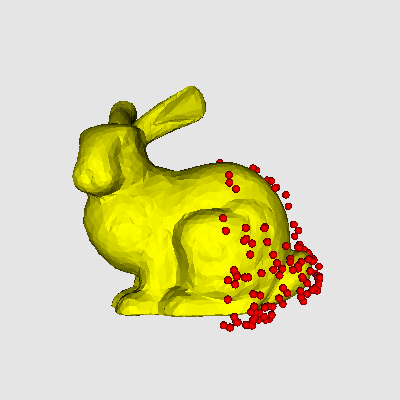

In [3]:
from vtk import (vtkTriangleFilter)
import random

reader = vtkOBJReader()
reader.SetFileName('./data/bunny.obj')
mapper = vtkPolyDataMapper()
mapper.SetInputConnection(reader.GetOutputPort())

actor = vtkActor()
actor.SetMapper(mapper)
actor.GetProperty().SetColor(1,1,0)

renderer = vtkRenderer()
renderer.AddActor(actor)
renderer.SetBackground(0.9, 0.9, 0.9)
    
obbTree = vtk.vtkOBBTree()
#obbTree.SetDataSet(mesh)
reader.Update()
obbTree.SetDataSet(reader.GetOutput())
obbTree.BuildLocator()
#print obbTree

for i in range(200):

    points = vtk.vtkPoints()
    cellIds = vtk.vtkIdList()

    code = obbTree.IntersectWithLine((200.0 * random.uniform(0, 1), 200.0 * random.uniform(0, 1), 200.0 * random.uniform(0, 1)), (0.0, 0.0, 0.0), points, cellIds)
    
    if points.GetNumberOfPoints() > 0:

        #print points[0]
        source = vtk.vtkSphereSource()
        source.SetPhiResolution(200)
        source.SetThetaResolution(200)
        source.SetCenter(points.GetPoint(0))
        source.SetRadius(0.0025)

        pointMapper = vtk.vtkPolyDataMapper()
        pointMapper.SetInputConnection(source.GetOutputPort())
        actor = vtkActor()
        actor.SetMapper(pointMapper)
        actor.GetProperty().SetColor(1,0,0)
        renderer.AddActor(actor)

print reader.GetOutput().GetBounds()

vtk_show(renderer, 400, 400)



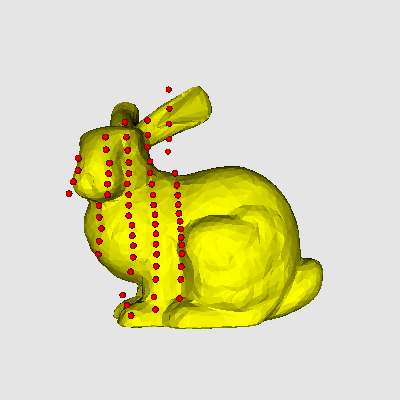

In [4]:
from vtk import (vtkTriangleFilter)
import random
import math
import numpy
from numpy import cross, eye, dot
from scipy.linalg import expm, norm

def AxisAngleRot(axis, theta):
    axis = numpy.asarray(axis)
    #print axis, norm(axis), theta, axis/norm(axis),axis/norm(axis)*theta
    return expm(cross(eye(3), axis/norm(axis)*theta))
def AxisAngleRotate(axis, theta, v):
    return (dot(AxisAngleRot(axis, theta),v)).tolist()
v, axis, theta = [3,5,0], [4,4,1], 1.2
AxisAngleRot(axis, theta)
#print AxisAngleRotate(axis, theta, v)

reader = vtkOBJReader()
reader.SetFileName('./data/bunny.obj')
mapper = vtkPolyDataMapper()
mapper.SetInputConnection(reader.GetOutputPort())

actor = vtkActor()
actor.SetMapper(mapper)
actor.GetProperty().SetColor(1,1,0)

renderer = vtkRenderer()
renderer.AddActor(actor)
renderer.SetBackground(0.9, 0.9, 0.9)
    
obbTree = vtk.vtkOBBTree()
#obbTree.SetDataSet(mesh)
reader.Update()
obbTree.SetDataSet(reader.GetOutput())
obbTree.BuildLocator()
#print obbTree

centerPt = ((reader.GetOutput().GetBounds()[0]+reader.GetOutput().GetBounds()[1]) / 2.0,
         (reader.GetOutput().GetBounds()[2]+reader.GetOutput().GetBounds()[3]) / 2.0,
         (reader.GetOutput().GetBounds()[4]+reader.GetOutput().GetBounds()[5]) / 2.0)



lid_vFOV = 40.0
lid_nRows = 20
lid_hRotStep = 10.0
lid_nRotSteps = 6
lid_source = ((reader.GetOutput().GetBounds()[0]+reader.GetOutput().GetBounds()[1]) / 2.0,
             (reader.GetOutput().GetBounds()[2]+reader.GetOutput().GetBounds()[3]) / 2.0,
             reader.GetOutput().GetBounds()[5] * 2.0)
lid_fwd = [0.0,0.0,-1.0]
lid_right = [1.0,0.0,0.0]
lid_up = [0.0,1.0,0.0]
lid_scanAngles = [-lid_vFOV*(1.0*x/(lid_nRows-1)) + lid_vFOV*(1.0-(1.0*x/(lid_nRows-1))) for x in range(lid_nRows)]
#print lid_scanAngles
lid_scanAnglesRad = [(x/180)*math.pi for x in lid_scanAngles]
lid_scanDirs = [AxisAngleRotate(lid_right,x, lid_fwd) for x in lid_scanAnglesRad]
lid_scanRayTargets = []

for i in range(lid_nRotSteps):
    lid_scanDirs = [AxisAngleRotate(lid_up,lid_hRotStep/180.0*math.pi, x) for x in lid_scanDirs]
    #print 'XXX', lid_scanDirs
    lid_scanLines = [(x[0]*100.0, x[1]*100.0, x[2]*100.0) for x in lid_scanDirs]
    lid_scanRayTargets = lid_scanRayTargets + [(lid_source[0]+x[0], lid_source[1]+x[1], lid_source[2]+x[2]) for x in lid_scanLines]
    #print lid_scanRayTargets


if False:
    source = vtk.vtkSphereSource()
    source.SetPhiResolution(200)
    source.SetThetaResolution(200)
    source.SetCenter(srcPt)
    source.SetRadius(0.005)

    pointMapper = vtk.vtkPolyDataMapper()
    pointMapper.SetInputConnection(source.GetOutputPort())
    actor = vtkActor()
    actor.SetMapper(pointMapper)
    actor.GetProperty().SetColor(1,0,1)
    renderer.AddActor(actor)

for targetPt in lid_scanRayTargets:

    points = vtk.vtkPoints()
    cellIds = vtk.vtkIdList()

   
    code = obbTree.IntersectWithLine(lid_source, targetPt, points, cellIds)      
    
    if code == 1:
    #and points.GetNumberOfPoints() > 4:

        #print points[0]
        source = vtk.vtkSphereSource()
        source.SetPhiResolution(200)
        source.SetThetaResolution(200)
        source.SetCenter(points.GetPoint(0))
        source.SetRadius(0.002)

        pointMapper = vtk.vtkPolyDataMapper()
        pointMapper.SetInputConnection(source.GetOutputPort())
        actor = vtkActor()
        actor.SetMapper(pointMapper)
        actor.GetProperty().SetColor(1,0,0)
        renderer.AddActor(actor)

#print reader.GetOutput().GetBounds()

vtk_show(renderer, 400, 400)




0


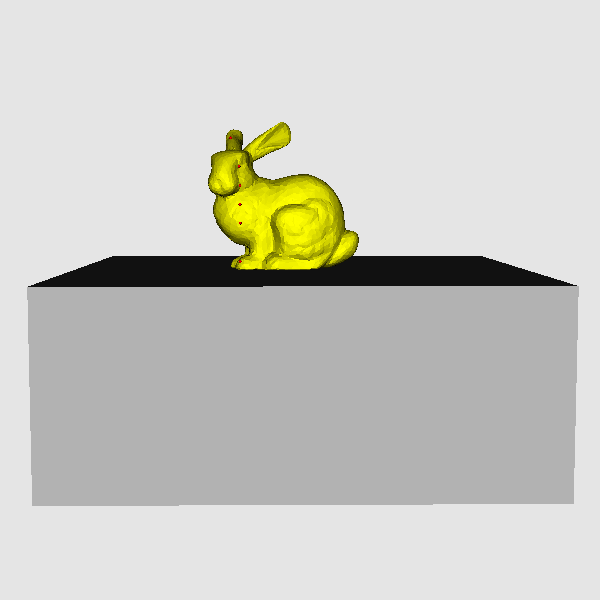

In [43]:
from vtk import (vtkTriangleFilter, vtkTransformPolyDataFilter, vtkTransform, vtkCubeSource)
import random
import math
import numpy
from numpy import cross, eye, dot
from scipy.linalg import expm, norm

def AxisAngleRot(axis, theta):
    axis = numpy.asarray(axis)
    #print axis, norm(axis), theta, axis/norm(axis),axis/norm(axis)*theta
    return expm(cross(eye(3), axis/norm(axis)*theta))
def AxisAngleRotate(axis, theta, v):
    return (dot(AxisAngleRot(axis, theta),v)).tolist()
v, axis, theta = [3,5,0], [4,4,1], 1.2
AxisAngleRot(axis, theta)
#print AxisAngleRotate(axis, theta, v)

reader = vtkOBJReader()
reader.SetFileName('./data/bunny.obj')

reader.Update()
#print 'XX', reader.GetOutput().GetBounds()

transformFilter = vtkTransformPolyDataFilter()
transformFilter.SetInputData(reader.GetOutput())
transform = vtkTransform()
transform.Identity()
extents = [reader.GetOutput().GetBounds()[2*x+1]-reader.GetOutput().GetBounds()[2*x] for x in range(3)]
normFactor = min([1.0/x] for x in extents)[0]
#print normFactor
transform.Scale([normFactor,normFactor,normFactor])
transformFilter.SetTransform(transform)
mapper = vtkPolyDataMapper()
#mapper.SetInputConnection(reader.GetOutputPort())
mapper.SetInputConnection(transformFilter.GetOutputPort())

transformFilter.Update()
polyData = transformFilter.GetOutput()

actor = vtkActor()
actor.SetMapper(mapper)
actor.GetProperty().SetColor(1,1,0)

renderer = vtkRenderer()
renderer.AddActor(actor)
renderer.SetBackground(0.9, 0.9, 0.9)
    
obbTree = vtk.vtkOBBTree()
#obbTree.SetDataSet(mesh)
reader.Update()
transformFilter.Update()
obbTree.SetDataSet(polyData)
obbTree.BuildLocator()
#print obbTree

cam_source = ((polyData.GetBounds()[0]+polyData.GetBounds()[1]) / 2.0,
                 (polyData.GetBounds()[2]+polyData.GetBounds()[3]) / 2.0,
                 polyData.GetBounds()[5] * 20.0)
#print renderer.GetActiveCamera().GetPosition()
renderer.GetActiveCamera().SetPosition(cam_source)
print renderer.GetLights().GetNumberOfItems()

if True:
    _source = vtk.vtkCubeSource()
    _source.SetBounds(-1.5,1.5,-1,polyData.GetBounds()[2],-1.5,1.5)
    
    _pointMapper = vtk.vtkPolyDataMapper()
    _pointMapper.SetInputConnection(_source.GetOutputPort())
    _actor = vtkActor()
    _actor.SetMapper(_pointMapper)
    _actor.GetProperty().SetColor(0.7,0.7,0.7)
    renderer.AddActor(_actor)

centerPt = ((polyData.GetBounds()[0]+polyData.GetBounds()[1]) / 2.0,
             (polyData.GetBounds()[2]+polyData.GetBounds()[3]) / 2.0,
             (polyData.GetBounds()[4]+polyData.GetBounds()[5]) / 2.0)



lid_vFOV = 40.0
lid_nRows = 20
lid_hRotStep = 10.0
lid_nRotSteps = 6
lid_source = ((polyData.GetBounds()[0]+polyData.GetBounds()[1]) / 2.0,
                 (polyData.GetBounds()[2]+polyData.GetBounds()[3]) / 2.0,
                 polyData.GetBounds()[5] * 5.0)
lid_fwd = [0.0,0.0,-1.0]
lid_right = [1.0,0.0,0.0]
lid_up = [0.0,1.0,0.0]
lid_scanAngles = [-lid_vFOV*(1.0*x/(lid_nRows-1)) + lid_vFOV*(1.0-(1.0*x/(lid_nRows-1))) for x in range(lid_nRows)]
#print lid_scanAngles
lid_scanAnglesRad = [(x/180)*math.pi for x in lid_scanAngles]
lid_scanDirs = [AxisAngleRotate(lid_right,x, lid_fwd) for x in lid_scanAnglesRad]
lid_scanRayTargets = []


for i in range(lid_nRotSteps):
    lid_scanDirs = [AxisAngleRotate(lid_up,lid_hRotStep/180.0*math.pi, x) for x in lid_scanDirs]
    #print 'XXX', lid_scanDirs
    lid_scanLines = [(x[0]*100.0, x[1]*100.0, x[2]*100.0) for x in lid_scanDirs]
    lid_scanRayTargets = lid_scanRayTargets + [(lid_source[0]+x[0], lid_source[1]+x[1], lid_source[2]+x[2]) for x in lid_scanLines]
    #print lid_scanRayTargets


if False:
    source = vtk.vtkSphereSource()
    source.SetPhiResolution(200)
    source.SetThetaResolution(200)
    source.SetCenter(srcPt)
    source.SetRadius(0.01)

    pointMapper = vtk.vtkPolyDataMapper()
    pointMapper.SetInputConnection(source.GetOutputPort())
    actor = vtkActor()
    actor.SetMapper(pointMapper)
    actor.GetProperty().SetColor(1,0,1)
    renderer.AddActor(actor)

for targetPt in lid_scanRayTargets:

    points = vtk.vtkPoints()
    cellIds = vtk.vtkIdList()

   
    code = obbTree.IntersectWithLine(lid_source, targetPt, points, cellIds)      
    
    if code == 1:
    #and points.GetNumberOfPoints() > 4:

        #print points[0]
        source = vtk.vtkSphereSource()
        source.SetPhiResolution(200)
        source.SetThetaResolution(200)
        source.SetCenter(points.GetPoint(0))
        source.SetRadius(0.01)

        pointMapper = vtk.vtkPolyDataMapper()
        pointMapper.SetInputConnection(source.GetOutputPort())
        actor = vtkActor()
        actor.SetMapper(pointMapper)
        actor.GetProperty().SetColor(1,0,0)
        renderer.AddActor(actor)

#print reader.GetOutput().GetBounds()

vtk_show(renderer, 600, 600)



